In [86]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_absolute_error
import pickle
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [87]:
DATA_FOLDER = f'data/'
TRAIN_DATA_FILE = os.path.join(DATA_FOLDER, 'train.feather')
TEST_DATA_FILE = os.path.join(DATA_FOLDER, 'test.feather')
MODEL_FOLDER = f'model/'
os.makedirs(MODEL_FOLDER, exist_ok=True)

TARGET = 'TOTALKWH'

In [88]:
# Load Yeo-Johnson transformer 
with open(os.path.join(DATA_FOLDER, 'yeo_johnson.pkl'), 'rb') as f:
    yeo_Johnson = pickle.load(f)

In [89]:
# Check for GPU availability
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {DEVICE}')

# Load data (assuming TRAIN_DATA_FILE and TEST_DATA_FILE are defined)
train_df = pd.read_feather(TRAIN_DATA_FILE)
test_df = pd.read_feather(TEST_DATA_FILE)

device: cuda


In [90]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51322 entries, 1153 to 50613
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   TOTALKWH    51322 non-null  float64       
 1   tempAvg     51322 non-null  float64       
 2   winddirAvg  51322 non-null  float64       
 3   population  51322 non-null  float64       
 4   density     51322 non-null  float64       
 5   month       51322 non-null  float64       
 6   month_sin   51322 non-null  float64       
 7   month_cos   51322 non-null  float64       
 8   zipcode     51322 non-null  float64       
 9   latitude    51322 non-null  float64       
 10  longitude   51322 non-null  float64       
 11  YEAR_MONTH  51322 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 5.1 MB


In [91]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12831 entries, 52310 to 66099
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   TOTALKWH    12831 non-null  float64       
 1   tempAvg     12831 non-null  float64       
 2   winddirAvg  12831 non-null  float64       
 3   population  12831 non-null  float64       
 4   density     12831 non-null  float64       
 5   month       12831 non-null  float64       
 6   month_sin   12831 non-null  float64       
 7   month_cos   12831 non-null  float64       
 8   zipcode     12831 non-null  float64       
 9   latitude    12831 non-null  float64       
 10  longitude   12831 non-null  float64       
 11  YEAR_MONTH  12831 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.3 MB


In [92]:
# Define series to scale and use
series_cols = [TARGET, 'winddirAvg', 'tempAvg', 'population', 'density', 'month_sin', 'month_cos']

FOLD = 8
SEQ_LEN = 3

# Model parameters
NUM_LAYERS = 2
INPUT_SIZE = len(series_cols)
HIDDEN_SIZE = 30
OUTPUT_SIZE = 1

# Training parameters
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=FOLD)

In [93]:
# Function to create sequences with target dates
def create_sequences(df, features):
    """
    Create sequences of data for LSTM model.
    
    Parameters:
    - df: DataFrame, input data
    - features: list of str, feature columns
    
    Returns:
    - X: np.ndarray, shape (n_samples, SEQ_LEN, n_features), input sequences
    - y: np.ndarray, shape (n_samples,), target values
    - dates: np.ndarray, shape (n_samples,), target dates
    
    Sample Usage:
    X, y, dates = create_sequences(train_df, series_cols)
    """
    X = []
    y = []
    dates = []
    for i in range(SEQ_LEN, len(df)):
        X.append(df.iloc[i - SEQ_LEN:i][features].values)
        y.append(df.iloc[i][TARGET])
        dates.append(df.iloc[i]['YEAR_MONTH'])
    return np.array(X), np.array(y), np.array(dates)

In [94]:
# Create training sequences with dates
X_train, y_train, dates_train = create_sequences(train_df, series_cols)

# Sort training sequences by target date
sorted_indices = np.argsort(dates_train)
X_train_sorted = X_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]

In [95]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        
        # Dense block with dropout
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_prob)
        
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout_prob)
        
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(DEVICE)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(DEVICE)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # take the last timestep
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.drop1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        
        out = self.fc3(out)
        return out

In [96]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error


def plot_losses(train_losses, val_losses):
    """
    Plot training and validation loss curves.

    Parameters:
    - train_losses: list of floats, training loss values
    - val_losses: list of floats, validation loss values

    Returns:
    - None

    Sample Usage:
    plot_losses(train_losses, val_losses)
    """
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
    
def inverse_yeo_johnson(yeo_Johnson, arr):
    """
    Apply inverse Yeo-Johnson transformation to an array using a fitted transformer.

    Parameters:
    - yeo_Johnson: PowerTransformer, fitted Yeo-Johnson transformer
    - arr: array-like, shape (n_samples,), array to inverse transform

    Returns:
    - original_arr: np.ndarray, shape (n_samples,), array after inverse transformation

    Sample Usage:
    original = inverse_yeo_johnson(yeo_transformer, transformed_array)
    """
    arr = np.array(arr).reshape(-1, 1)
    dummy_array = np.zeros((arr.shape[0], yeo_Johnson.n_features_in_))
    dummy_array[:, 0] = arr[:, 0]
    inverse_transformed = yeo_Johnson.inverse_transform(dummy_array)
    original_arr = inverse_transformed[:, 0]
    return original_arr

def initialize_model():
    """
    Initialize the LSTM model, loss function, and optimizer.

    Returns:
    - model: LSTM model instance
    - criterion: loss function (MSELoss)
    - optimizer: Adam optimizer instance

    Sample Usage:
    model, criterion, optimizer = initialize_model(10, 64, 2, 1, DEVICE, 0.001)
    """
    model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    return model, criterion, optimizer

def create_dataloaders(X_train_fold, y_train_fold, X_val_fold, y_val_fold):
    """
    Create training and validation dataloaders.

    Parameters:
    - X_train_fold, y_train_fold: training features and labels
    - X_val_fold, y_val_fold: validation features and labels
    - y_train_fold: array-like, shape (n_samples,), training labels
    - y_val_fold: array-like, shape (n_samples,), validation labels

    Returns:
    - train_loader: DataLoader for training set
    - val_loader: DataLoader for validation set

    Sample Usage:
    train_loader, val_loader = create_dataloaders(X_train, y_train, X_val, y_val, 32, DEVICE)
    """
    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold).to(DEVICE), 
                                  torch.FloatTensor(y_train_fold).to(DEVICE))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold).to(DEVICE), 
                                torch.FloatTensor(y_val_fold).to(DEVICE))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, val_loader

def train_one_epoch(model, train_loader, criterion, optimizer):
    """
    Train the model for one epoch.

    Parameters:
    - model: LSTM model
    - train_loader: DataLoader, training data
    - criterion: loss function
    - optimizer: optimizer

    Returns:
    - avg_train_loss: float, average training loss

    Sample Usage:
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    """
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    return train_loss / len(train_loader.dataset)

def evaluate_one_epoch(model, val_loader, criterion):
    """
    Evaluate the model for one epoch.

    Parameters:
    - model: LSTM model
    - val_loader: DataLoader, validation data
    - criterion: loss function

    Returns:
    - avg_val_loss: float, average validation loss

    Sample Usage:
    val_loss = evaluate_one_epoch(model, val_loader, criterion)
    """
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            val_loss += loss.item() * X_batch.size(0)
    return val_loss / len(val_loader.dataset)

def save_best_model(model, val_loss, best_val_loss):
    """
    Save the model if validation loss improves.

    Parameters:
    - model: LSTM model
    - val_loss: float, current validation loss
    - best_val_loss: float, best validation loss so far
    - MODEL_FOLDER: str, directory to save model

    Returns:
    - best_val_loss: updated best validation loss
    - early_stop_flag: int, 0 if improved, 1 if no improvement

    Sample Usage:
    best_val_loss, flag = save_best_model(model, val_loss, best_val_loss, "models/")
    """
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(MODEL_FOLDER, 'best_model_fold.pth'))
        return best_val_loss, 0
    else:
        return best_val_loss, 1

def load_and_evaluate_best_model(model, X_val_fold, y_val_fold):
    """
    Load the best saved model and evaluate on the validation set.

    Parameters:
    - model: LSTM model
    - X_val_fold, y_val_fold: validation features and labels
    - MODEL_FOLDER: str, directory where the model is saved

    Returns:
    - mse_val: float, mean squared error on validation
    - r2_val: float, R² score on validation
    - rmse_val: float, root mean squared error on validation

    Sample Usage:
    mse_val, r2_val, rmse_val = load_and_evaluate_best_model(model, X_val, y_val, "models/")
    """
    model.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, 'best_model_fold.pth')))
    model.eval()
    with torch.no_grad():
        y_pred_val = model(torch.FloatTensor(X_val_fold).to(DEVICE)).squeeze().cpu().numpy()

    mse_val = mean_squared_error(y_val_fold, y_pred_val)
    r2_val = r2_score(y_val_fold, y_pred_val)
    rmse_val = root_mean_squared_error(y_val_fold, y_pred_val)
    print(f'Validation MSE: {mse_val:.4f}, R²: {r2_val:.4f}, RMSE: {rmse_val:.4f}')
    return mse_val, r2_val, rmse_val

def train_and_evaluate(X_train_fold, y_train_fold, X_val_fold, y_val_fold, patience=5):
    """
    Train and evaluate the LSTM model with early stopping.

    Parameters:
    - MODEL_FOLDER: str, directory to save the best model
    - X_train_fold, y_train_fold: training features and labels
    - X_val_fold, y_val_fold: validation features and labels
    - patience: int, early stopping patience

    Returns:
    - mse_val: float, final validation mse
    - r2_val: float, final validation R² score

    Sample Usage:
    mse, r2 = train_and_evaluate("models/", X_train, y_train, X_val, y_val, 10, 64, 2, 1)
    """
    model, criterion, optimizer = initialize_model()
    train_loader, val_loader = create_dataloaders(X_train_fold, y_train_fold, X_val_fold, y_val_fold)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    counter = 0
    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss = evaluate_one_epoch(model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        best_val_loss, early_stop_flag = save_best_model(model, val_loss, best_val_loss)
        counter += early_stop_flag
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    plot_losses(train_losses, val_losses)
    mse_val, r2_val, rmse_val = load_and_evaluate_best_model(model, X_val_fold, y_val_fold)

    return mse_val, r2_val, rmse_val

In [97]:
# # Function to train and evaluate a model for one fold
# def train_and_evaluate(MODEL_FOLDER, 
#                        X_train_fold, y_train_fold, X_val_fold, y_val_fold, 
#                        INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, output_size, 
#                        DEVICE, patience=5, batch_size=BATCH_SIZE, epochs=EPOCHS, 
#                        learning_rate=LEARNING_RATE):
#     model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, output_size).to(DEVICE)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     
#     train_dataset = TensorDataset(torch.FloatTensor(X_train_fold).to(DEVICE), torch.FloatTensor(y_train_fold).to(DEVICE))
#     val_dataset = TensorDataset(torch.FloatTensor(X_val_fold).to(DEVICE), torch.FloatTensor(y_val_fold).to(DEVICE))
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#     
#     best_val_loss = float('inf')
#     train_losses, val_losses = [], []
#     counter = 0  # For early stopping
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0
#         for X_batch, y_batch in train_loader:
#             optimizer.zero_grad()
#             output = model(X_batch)
#             loss = criterion(output.squeeze(), y_batch)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * X_batch.size(0)
#         train_loss /= len(train_dataset)
#         train_losses.append(train_loss)
#         
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for X_batch, y_batch in val_loader:
#                 output = model(X_batch)
#                 loss = criterion(output.squeeze(), y_batch)
#                 val_loss += loss.item() * X_batch.size(0)
#         val_loss /= len(val_dataset)
#         val_losses.append(val_loss)
#         print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
#         
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), 
#                        os.path.join(MODEL_FOLDER, 'best_model_fold.pth'))
#             counter = 0
#         else:
#             counter += 1
#             if counter >= patience:
#                 print(f'Early stopping at epoch {epoch}')
#                 break
#     
#     # Plot training and validation loss
#     plot_losses(train_losses, val_losses)
#     
#     # Load best model for this fold
#     model.load_state_dict(torch.load(
#         os.path.join(MODEL_FOLDER, 'best_model_fold.pth')))
#     print('Best model loaded for evaluation')
#     
#     model.eval()
#     with torch.no_grad():
#         y_pred_val = model(torch.FloatTensor(X_val_fold).to(DEVICE)).squeeze().cpu().numpy()
#     # y_val_original = yeo_Johnson.inverse_transform(y_val_fold.reshape(-1, 1)).flatten()
#     # y_pred_original = yeo_Johnson.inverse_transform(y_pred_val.reshape(-1, 1)).flatten()
#     # y_val_original = inverse_yeo_johnson(yeo_Johnson, y_val_fold)
#     # y_pred_original = inverse_yeo_johnson(yeo_Johnson, y_pred_val)
#     # mse_val, r2_val = calculate_metrics(y_val_original, y_pred_original)
#     mse_val = mean_absolute_percentage_error(y_val_fold, y_pred_val)
#     r2_val = r2_score(y_val_fold, y_pred_val)
#     
#     print(f'Validation mse: {mse_val * 100:.2f}%, R²: {r2_val:.4f}')
#     return mse_val, r2_val

Training on fold 1/8
Epoch 1/100, Train Loss: 0.7683, Val Loss: 0.7538
Epoch 11/100, Train Loss: 0.6095, Val Loss: 0.6725
Early stopping at epoch 12


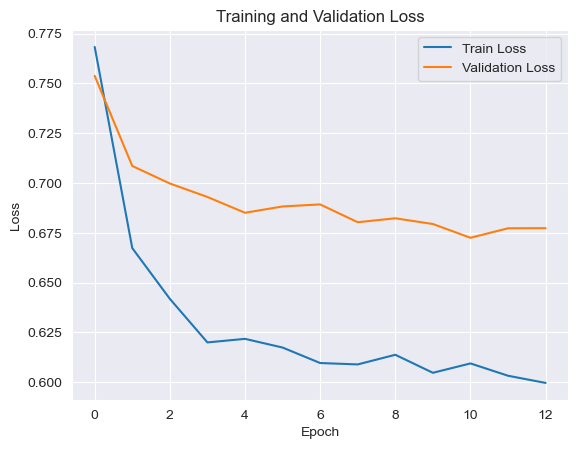

Validation MSE: 0.6725, R²: 0.3019, RMSE: 0.8201
Training on fold 2/8
Epoch 1/100, Train Loss: 0.7718, Val Loss: 0.6600
Epoch 11/100, Train Loss: 0.6247, Val Loss: 0.6127
Early stopping at epoch 16


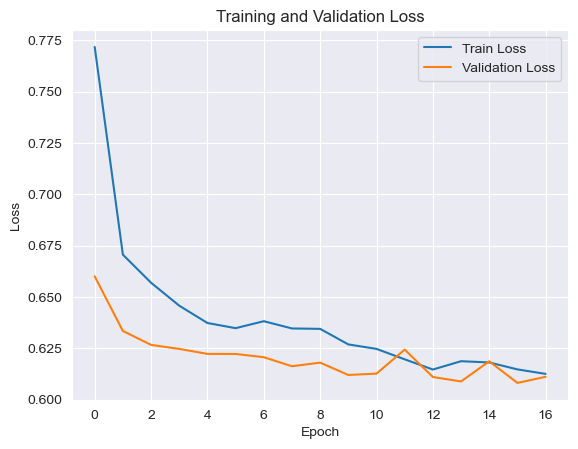

Validation MSE: 0.6081, R²: 0.3398, RMSE: 0.7798
Training on fold 3/8
Epoch 1/100, Train Loss: 0.7397, Val Loss: 0.7595
Epoch 11/100, Train Loss: 0.6242, Val Loss: 0.7104
Epoch 21/100, Train Loss: 0.6013, Val Loss: 0.6877
Early stopping at epoch 20


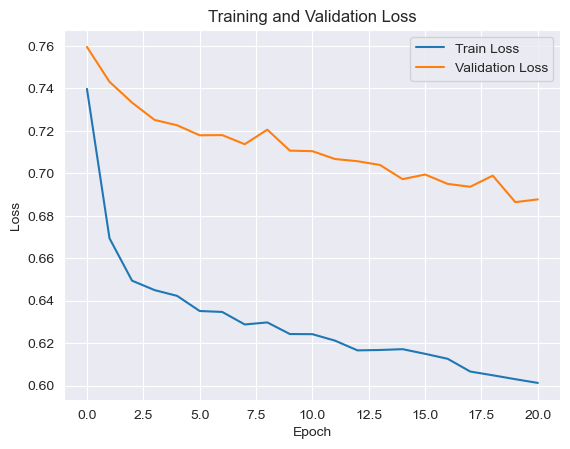

Validation MSE: 0.6864, R²: 0.3347, RMSE: 0.8285
Training on fold 4/8
Epoch 1/100, Train Loss: 0.7490, Val Loss: 0.7167
Epoch 11/100, Train Loss: 0.6407, Val Loss: 0.6764
Early stopping at epoch 17


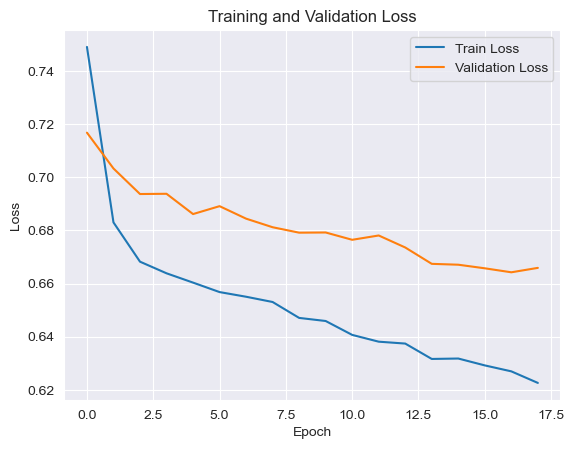

Validation MSE: 0.6642, R²: 0.3362, RMSE: 0.8150
Training on fold 5/8
Epoch 1/100, Train Loss: 0.7446, Val Loss: 0.7386
Epoch 11/100, Train Loss: 0.6450, Val Loss: 0.6946
Early stopping at epoch 18


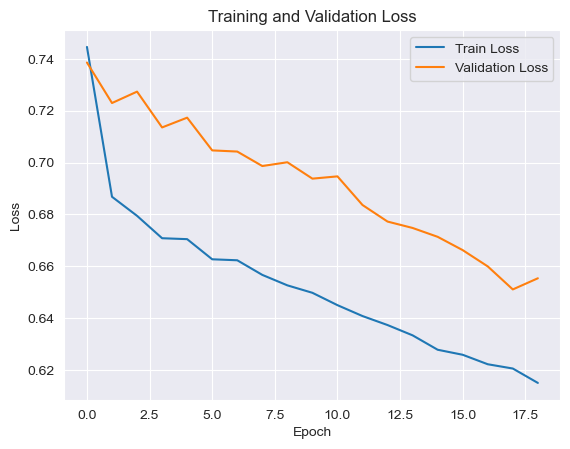

Validation MSE: 0.6510, R²: 0.3751, RMSE: 0.8069
Training on fold 6/8
Epoch 1/100, Train Loss: 0.7506, Val Loss: 0.7501
Epoch 11/100, Train Loss: 0.6594, Val Loss: 0.7026
Epoch 21/100, Train Loss: 0.6147, Val Loss: 0.6624
Early stopping at epoch 20


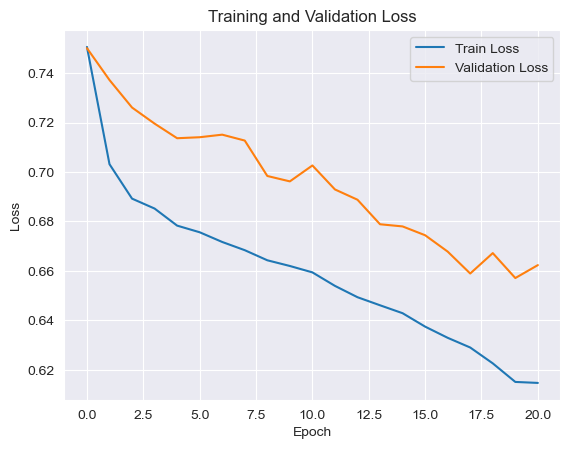

Validation MSE: 0.6571, R²: 0.3849, RMSE: 0.8106
Training on fold 7/8
Epoch 1/100, Train Loss: 0.7613, Val Loss: 0.7065
Epoch 11/100, Train Loss: 0.6573, Val Loss: 0.6575
Epoch 21/100, Train Loss: 0.6078, Val Loss: 0.5949
Epoch 31/100, Train Loss: 0.5670, Val Loss: 0.5558
Early stopping at epoch 30


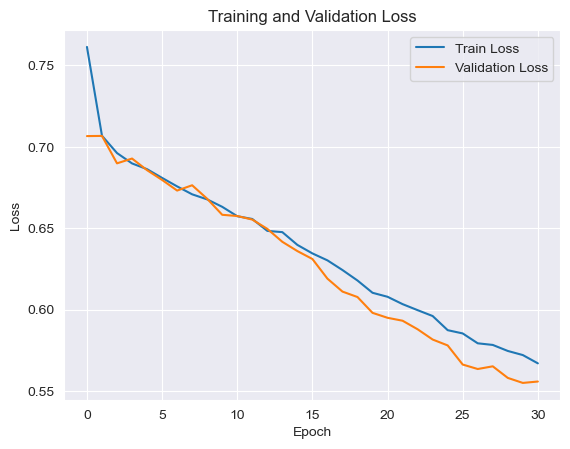

Validation MSE: 0.5550, R²: 0.4462, RMSE: 0.7450
Training on fold 8/8
Epoch 1/100, Train Loss: 0.7528, Val Loss: 0.7610
Epoch 11/100, Train Loss: 0.6477, Val Loss: 0.6898
Epoch 21/100, Train Loss: 0.5969, Val Loss: 0.6259
Epoch 31/100, Train Loss: 0.5595, Val Loss: 0.5813
Epoch 41/100, Train Loss: 0.5305, Val Loss: 0.5344
Early stopping at epoch 47


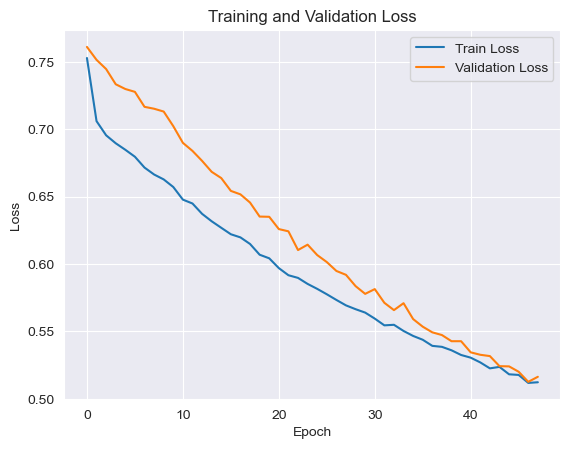

Validation MSE: 0.5125, R²: 0.5230, RMSE: 0.7159
Cross-Validation MSE: 0.6259 ± 0.0582
Cross-Validation R²: 0.3802 ± 0.0676
Cross-Validation RMSE: 0.7902 ± 0.0377


In [98]:
# Perform TSCV
mse_scores = []
rmse_scores = []
r2_scores = []
for train_idx, val_idx in tscv.split(X_train_sorted):
    print(f'Training on fold {len(mse_scores) + 1}/{FOLD}')
    X_train_fold = X_train_sorted[train_idx]
    y_train_fold = y_train_sorted[train_idx]
    X_val_fold = X_train_sorted[val_idx]
    y_val_fold = y_train_sorted[val_idx]
    
    mse_val, r2_val, rmse_val = train_and_evaluate(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
    mse_scores.append(mse_val)
    r2_scores.append(r2_val)
    rmse_scores.append(rmse_val)

print(f"Cross-Validation MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
print(f"Cross-Validation R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"Cross-Validation RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")

In [99]:
# Refit final model on entire training set with early stopping
train_idx, val_idx = list(tscv.split(X_train_sorted))[-1]
X_train_final = X_train_sorted[train_idx]
y_train_final = y_train_sorted[train_idx]
X_val_final = X_train_sorted[val_idx]
y_val_final = y_train_sorted[val_idx]

# Train final model
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_dataset = TensorDataset(torch.FloatTensor(X_train_final).to(DEVICE), 
                              torch.FloatTensor(y_train_final).to(DEVICE))
val_dataset = TensorDataset(torch.FloatTensor(X_val_final).to(DEVICE), 
                            torch.FloatTensor(y_val_final).to(DEVICE))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Epoch 1/100, Train Loss: 0.7579, Val Loss: 0.7687
Epoch 11/100, Train Loss: 0.6564, Val Loss: 0.6988
Epoch 21/100, Train Loss: 0.5993, Val Loss: 0.6276
Epoch 31/100, Train Loss: 0.5579, Val Loss: 0.5767
Epoch 41/100, Train Loss: 0.5307, Val Loss: 0.5287
Epoch 51/100, Train Loss: 0.5010, Val Loss: 0.4981
Epoch 61/100, Train Loss: 0.4763, Val Loss: 0.4655
Epoch 71/100, Train Loss: 0.4602, Val Loss: 0.4477
Early stopping at epoch 78


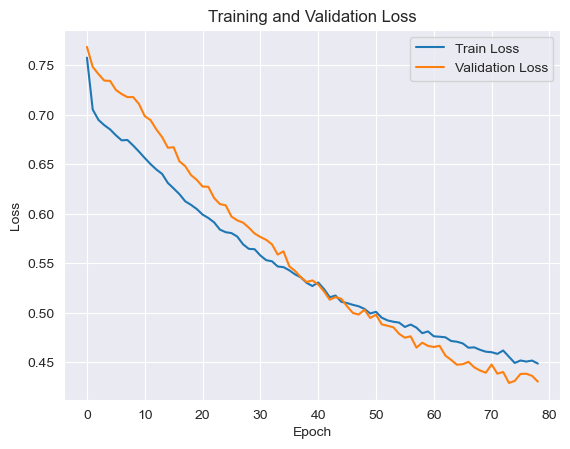

In [100]:
best_val_loss = float('inf')
patience = 5
counter = 0
train_losses, val_losses = [], []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(MODEL_FOLDER, 'best_model_final.pth'))
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
            
# Plot training and validation loss
plot_losses(train_losses, val_losses)

In [101]:
# Load best final model
model.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, 'best_model_final.pth')))
model.eval()

# Create test sequences
if len(test_df) >= SEQ_LEN:
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    X_all, y_all, _ = create_sequences(combined_df, series_cols)
    start_test = max(0, len(train_df) - SEQ_LEN)
    end_test = len(combined_df) - SEQ_LEN
    X_test = X_all[start_test:end_test]
    y_test = y_all[start_test:end_test]
else:
    X_test = np.array([])
    y_test = np.array([])

In [102]:
# Predict on test data
model.eval()
with torch.no_grad():
    y_pred_scaled = model(torch.FloatTensor(X_test).to(DEVICE)).squeeze().cpu().numpy()
y_test_scaled = y_test

# Inverse transform predictions and actual values
y_test_original = inverse_yeo_johnson(yeo_Johnson, y_test_scaled)
y_pred_original = inverse_yeo_johnson(yeo_Johnson, y_pred_scaled)

# Calculate evaluation metrics on test set
mse_test = mean_squared_error(y_test_original, y_pred_original)
r2_test = r2_score(y_test_original, y_pred_original)
mae_test = mean_absolute_error(y_test_original, y_pred_original)
rmse_test = root_mean_squared_error(y_test_original, y_pred_original)

print(f'Test MSE: {mse_test:.4f}')
print(f'Test R²: {r2_test:.4f}')
print(f'Test MAE: {mae_test:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')

Test MSE: 173968328218307.5312
Test R²: 0.2164
Test MAE: 3852108.6832
Test RMSE: 13189705.3879


D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Feature importance table saved to model/feature_importance.csv
Feature importance plot saved to model/feature_importance.png


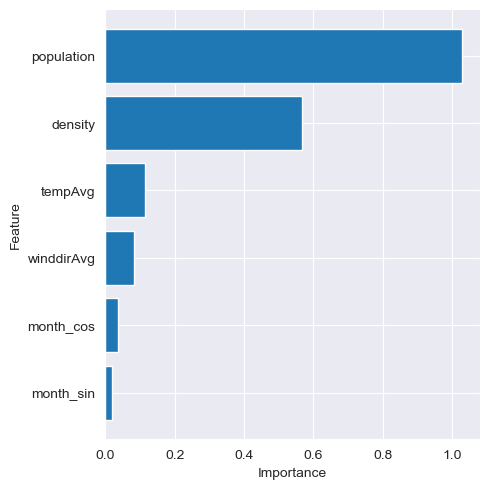

In [106]:
def plot_feature_importance(importances, feature_names, save_path):

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=True)

    # save importance_df to csv
    importance_df.to_csv(save_path.replace('.png', '.csv'), index=False)
    print(f"Feature importance table saved to {save_path.replace('.png', '.csv')}")

    plt.figure(figsize=(5, 5))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Feature importance plot saved to {save_path}")
    plt.show()

def lstm_feature_importance(model, X_tensor, y_tensor, save_path, feature_names, n_repeats=10, random_state=42):
    model = model.to(DEVICE)
    model.eval()
    np.random.seed(random_state)

    # baseline performance
    with torch.no_grad():
        preds = model(X_tensor.to(DEVICE)).cpu().numpy()
    baseline_score = mean_squared_error(y_tensor.cpu().numpy(), preds)

    importances = np.zeros(X_tensor.shape[2] - 1) # excluding target variable

    for i in range(1, X_tensor.shape[2]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_tensor.clone()
            idx = torch.randperm(X_tensor.shape[0])
            X_permuted[:, :, i] = X_tensor[idx, :, i]

            with torch.no_grad():
                preds_permuted = model(X_permuted.to(DEVICE)).cpu().numpy()
            score = mean_squared_error(y_tensor.cpu().numpy(), preds_permuted)
            scores.append(score - baseline_score)

        importances[i - 1] = np.mean(scores)

    plot_feature_importance(importances, feature_names, save_path)
    
lstm_feature_importance(
    model=model,
    X_tensor=torch.FloatTensor(X_train_sorted).to(DEVICE),
    y_tensor=torch.FloatTensor(y_train_sorted).to(DEVICE),
    save_path=os.path.join(MODEL_FOLDER, 'feature_importance.png'),
    feature_names=series_cols[1:]  # Exclude target variable
)